In [1]:
import tweepy as tw
import pandas as pd
import json

# App Auth
consumer_key = 'a'
consumer_secret = 'b'
access_key = 'c'
access_secret = 'd'

# Initialize API
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)
api = tw.API(auth, wait_on_rate_limit=True)

# Search terms
search_words = ["#coronavirus", "#COVID19", "#CoronavirusOutbreak", "#CoronavirusPandemic"]
#                 , "#coronavirusindia", "#CoronavirusOutbreak", "#CoronavirusOutbreakindia", "#CoronavirusPandemic"]
date_since = "2020-03-10"

# Collect tweets
tweets = tw.Cursor(api.search,
              q=search_words,
              lang="en",
              since=date_since, tweet_mode='extended',
              include_rts=True).items(500000)

tweets_arr = []

# Iterate and print tweets
for tweet in tweets:
    tweets_arr.append(tweet._json)
print("Done")

with open("data.json", "w+") as output:
    output.write(json.dumps(tweets_arr))

Done


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


NB Model Accuracy: 0.8333333333333334
Analysing the twitter data
Counter({4.0: 5734, 5.0: 2738, 2.0: 2140, 1.0: 1635})


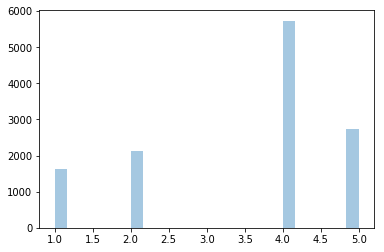

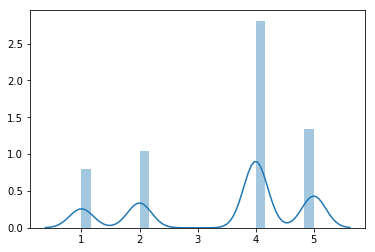

In [5]:
# NLP imports
import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

# pandas
import pandas as pd

# python imports
import re
import json
from collections import Counter
from matplotlib import pyplot as plt

# seaborn import
import seaborn as sns

# preprocessor data sources and instances
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words("english"))
ps = PorterStemmer()
tf = TfidfVectorizer()

Y = []
sentences = []
sentences_processed = []
sentences_processed_tw = []

# Reading data and creating sentences from data source
with open("./data/processed_stars_all/electronics_all_balanced.review", encoding='utf-8') as data:
    all_data = data.read().strip().split("\n")
    for n, line in enumerate(all_data):
        line_data = line.split(" ")[0:-1]
        sentence = ""
        for words_count in line_data:
            words = words_count.split(":")[0].split("_")
            count = int(words_count.split(":")[1])
            words = list(filter("<num>".__ne__, words))
            words = list(map(lambda x: re.sub(r'\`|\'|,|\.|\"', '', x), words))

            if len(words) == 0:
                continue
            words = words * count
            sentence += " ".join(words) + " "
        sentences.append(sentence)
        Y.append(float(line.split(" ")[-1].split(":")[-1]))

# Reading twitter data
with open("data.json") as twd:
    data = twd.read()
    json = json.loads(data)
    
    for tw in json:
        text = tw['full_text']
        # remove mentions, hashtags and punctuatoins
        text = re.sub(r'RT|@[a-zA-Z0-9_]+|:|#[a-zA-Z0-9_]+|[0-9]+|,|\'|\"|\`|…', '', text)
        text = re.sub(r'  ', ' ', text.strip())
        sentences_processed_tw.append(text)

# At this point we have sentences
for sentence in sentences:
    # Obtain work tokens
    tokenized_words = word_tokenize(sentence)
    # Remove stop words
    filtered_words = list(filter(lambda x: x not in stop_words, tokenized_words))
    # Stemming words (lematization is better but requires POS tagging which)
    stemmed_words = list(map(ps.stem, filtered_words))
    sentences_processed.append(" ".join(stemmed_words))

# Create a dataframe for downstream analysis
data = pd.DataFrame(data={'sentence': sentences_processed, 'sentiment': Y})

# Obtain TF-IDF transformation
text_tf = tf.fit_transform(data['sentence'])

# Split data into Test-Train sets
X_train, X_test, y_train, y_test = train_test_split(
    text_tf, data['sentiment'], test_size=0.001, random_state=1)

clf = MultinomialNB().fit(X_train, y_train)
predicted = clf.predict(X_test)

print("NB Model Accuracy:", metrics.accuracy_score(y_test, predicted))

print("Analysing the twitter data")

# Transforming to TF-IDF of our trained corpus
text_tf_tw = tf.transform(sentences_processed_tw)
predicted_tw = clf.predict(text_tf_tw)

print(Counter(predicted_tw))
sns.distplot(predicted_tw, kde=False, norm_hist=False)
plt.savefig("hist.png", dpi=300)
plt.figure()
sns.distplot(predicted_tw)
plt.savefig("hist_kde.png", dpi=300)
plt.show()
